### **Movies - Images and Text **

I will use the MMIMDB dataset (https://github.com/johnarevalo/gmu-mmimdb), collected by Arévalo, González, Solorio and Montes-y-Gómez from the Universidad Nacional de Colombia, University of Houston, INAOE-México. This dataset contains data corresponding to ~26,000 movies along with their plots (text) and their movie posters (images), and other information such as ratings and genres (categories). These are more movies than we will watch in a lifetime. We will use this dataset for movie genre classification. Each movie can be labeled with 27 categories of movies.

#### **1. Loading and Exploring the Dataset.**

##### **1.1 Dataset Download and Extraction**

First, we download the dataset, then we will create a Dataset class to load both the input movie posters (images), and input movie plots (texts), and the target movie genres (labels).

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
!gdown --id 1R2dcS8MxVEHwZdxw2iS1qpHxWVezNYFW -O /content/drive/My\ Drive/mmimdb-256.tar.gz
!tar -zxvf /content/drive/MyDrive/mmimdb-256.tar.gz -C /content/



流式输出内容被截断，只能显示最后 5000 行内容。
dataset-resized-256max/test/images/0117238.jpeg
dataset-resized-256max/test/images/0071676.jpeg
dataset-resized-256max/test/images/0134108.jpeg
dataset-resized-256max/test/images/0458375.jpeg
dataset-resized-256max/test/images/0075265.jpeg
dataset-resized-256max/test/images/0095031.jpeg
dataset-resized-256max/test/images/0342143.jpeg
dataset-resized-256max/test/images/0042546.jpeg
dataset-resized-256max/test/images/0045283.jpeg
dataset-resized-256max/test/images/0066019.jpeg
dataset-resized-256max/test/images/1946289.jpeg
dataset-resized-256max/test/images/0098253.jpeg
dataset-resized-256max/test/images/0052950.jpeg
dataset-resized-256max/test/images/0070122.jpeg
dataset-resized-256max/test/images/1093908.jpeg
dataset-resized-256max/test/images/0069303.jpeg
dataset-resized-256max/test/images/0030696.jpeg
dataset-resized-256max/test/images/0032701.jpeg
dataset-resized-256max/test/images/2793490.jpeg
dataset-resized-256max/test/images/0270645.jpeg
dataset-resiz

In [4]:
#!wget -nc http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
# I found downloading from Google Drive with gdown is a lot faster.
!pip -q install --upgrade --no-cache-dir gdown
#!gdown 173IhB80sQj2QfzTa10EsoUeEirb7LLlE
#!tar xf mmimdb-256.tar.gz
#!tar xf mmimdb-512.tar.gz # I also keep a copy with images resized at 512 pixels on their largest side.
!pip install livelossplot --quiet
!pip -q install transformers==4.26.0
!pip -q install sentencepiece
!pip -q install accelerate

##### **1.2 Defining the Data Loader**

In [5]:
import torch, os, json
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer
from PIL import Image

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset-resized-256max', split = 'dev',
                 image_transform = None,
                 tokenizer = RobertaTokenizer.from_pretrained('roberta-base')):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform
        self.tokenizer = tokenizer

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography',
                           'Comedy', 'Crime', 'Documentary', 'Drama',
                           'Family', 'Fantasy', 'Film-Noir', 'History',
                           'Horror', 'Music', 'Musical', 'Mystery', 'News',
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short',
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category)
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname))))
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')

        # Pre-tokenizing all sentences.
        # See documentation for what encode_plus does and each of its parameters.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        self.texts = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            if self.tokenizer:
              encoded_text = self.tokenizer.encode_plus(
                  text, add_special_tokens = True, truncation = True,
                  max_length = 256, padding = 'max_length',
                  return_attention_mask = True,
                  return_tensors = 'pt')
              self.tokenized_plots.append(encoded_text)
            self.texts.append(text)
        print(' finished')

    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')

        if self.tokenizer:
          text = self.tokenized_plots[index]['input_ids'][0]
          text_mask = self.tokenized_plots[index]['attention_mask'][0]
        else:
          text = self.texts[index]

        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        if self.tokenizer:
          return image, text, text_mask, label_vector
        else:
          return image, text, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def __len__(self):
        return len(self.metadata)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [6]:
# Loading the dataloader.
val_data = MovieDataset(split = 'dev')
print('Data size: %d samples' % len(val_data))

Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished
Data size: 2608 samples


##### **1.3 Testing the data loader**


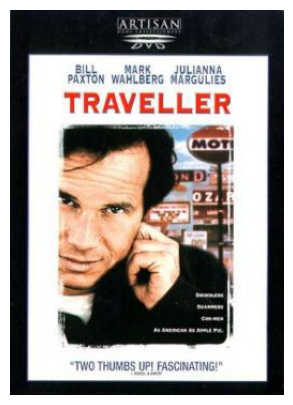

['A', 'Ġyoung', 'Ġman', ',', 'ĠPat', ',', 'Ġvisits', 'Ġthe', 'Ġclan', 'Ġof', 'Ġgy', 'psy', '-', 'like', 'Ġgr', 'if', 'ters', 'Ġ(', 'Irish', 'ĠTrave', 'llers', ')', 'Ġin', 'Ġrural', 'ĠNorth', 'ĠCarolina', 'Ġfrom', 'Ġwhom', 'Ġhe', 'Ġis', 'Ġdescended', '.', 'ĠHe', 'Ġis', 'Ġat', 'Ġfirst', 'Ġrejected', ',', 'Ġbut', 'Ġcousin', 'ĠBok', 'ky', 'Ġtakes', 'Ġhim', 'Ġon', 'Ġas', 'Ġan', 'Ġapprentice', '.', 'ĠPat', 'Ġlearns', 'Ġthe', 'Ġgame', 'Ġwhile', 'ĠBok', 'ky', 'Ġfalls', 'Ġin', 'Ġlove', 'Ġand', 'Ġdesires', 'Ġa', 'Ġdifferent', 'Ġlife', '.']
A young man, Pat, visits the clan of gypsy-like grifters (Irish Travellers) in rural North Carolina from whom he is descended. He is at first rejected, but cousin Bokky takes him on as an apprentice. Pat learns the game while Bokky falls in love and desires a different life.
['Crime', 'Drama', 'Romance']
Title:  Traveller
Kind:  movie
Year:  1997
Rating:  6.2


In [ ]:
import numpy as np

sample_movieID = 1247
# What is text_mask?
img, text, text_mask, labels = val_data[sample_movieID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(img); plt.axis(False);plt.show()

# Show input plot (untokenized).
tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)
print(tokens)
print(val_data.tokenizer.convert_tokens_to_string(tokens))

# Show target labels (converted back to strings from binary vector).
labels = labels.numpy()
# Is there a better way to do this?
print([val_data.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])

# You can look at other attributes for the movies on this dataset.
movie_metadata = val_data.get_metadata(sample_movieID)
print('Title: ', movie_metadata['smart canonical title'])
print('Kind: ', movie_metadata['kind'])
print('Year: ', movie_metadata['year'])
print('Rating: ', movie_metadata['rating'])

We explore below some of the images in the dataset that belong to the category `Drama`.

There are 1401 movies of type Drama among 2608


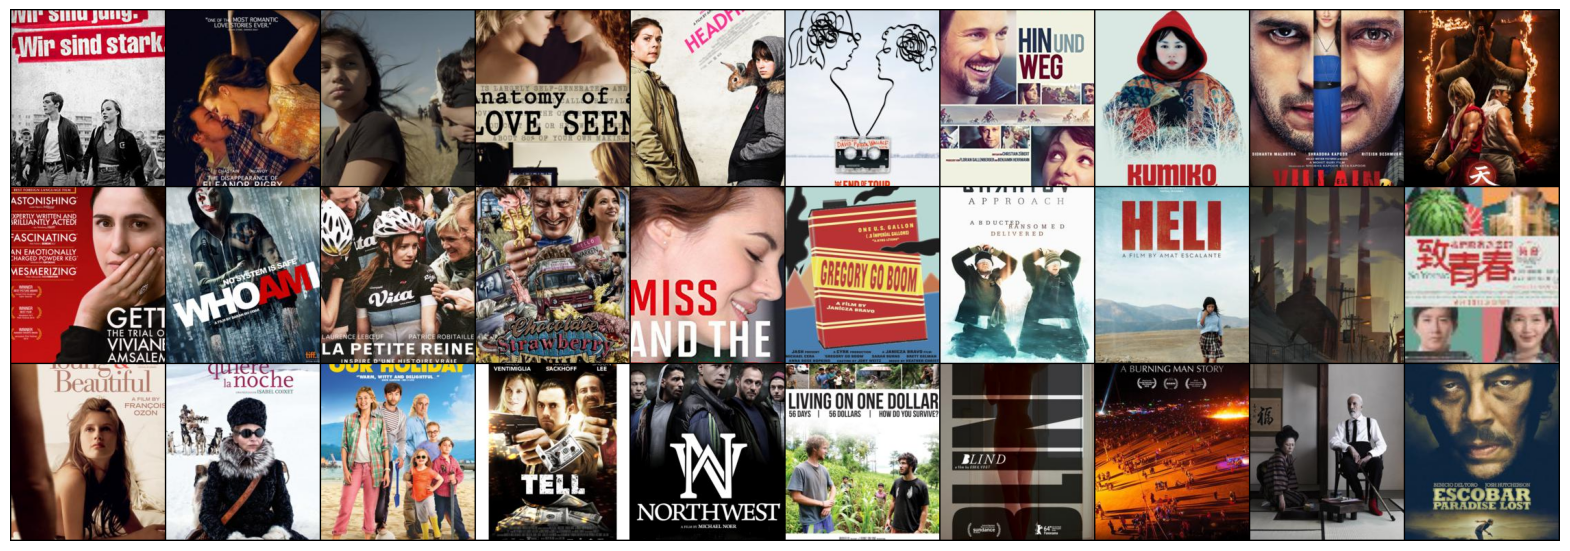

In [ ]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

# Now let's display a bunch of posters for Crime movies.
movieType = 'Drama'
crime_ids = [id for id in range(0, len(val_data))
             if movieType in set(val_data.get_metadata(id)['genres'])]

print('There are %d movies of type %s among %d' %
      (len(crime_ids), movieType, len(val_data)))

def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

# I'm passing the ids in reverse order, because it seems the movies are
# ordered from old to new in the dataset. Try the other way.
show_image_group(val_data, crime_ids[::-1], 30)

#### **2. Classify the Movies into Genres (based on their Plots -- Text Classification) **

##### **2.1. Setting up Data Loaders**

In the code below, we are loading the training, and validation splits and then testing the batch loaders.

In [7]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset,
                                         batch_size = batch_size,
                                         shuffle = False)

Loading dataset-resized-256max/train/metadata ... finished
Tokenizing... finished
Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


Testing what a sample batch looks like.

In [ ]:
(imgs, texts, text_masks, labels) = next(iter(val_loader))
print(imgs.shape, texts.shape, text_masks.shape, labels.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27])


##### **2.2. Loading the predefined RoBERTa Transformer Model**


In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig

# Defining as global the device to use (by default CPU).
device = torch.device("cuda")

# Loading RoBERTa...
num_categories = len(trainset.categories)
model = RobertaForSequenceClassification.from_pretrained('roberta-base',
    num_labels = num_categories,  output_attentions = False,
    output_hidden_states = False)

# Tell pytorch to run this model on the GPU.
model.to(device);

# Let's run a quick test on this model.
output = model(texts.to(device), text_masks.to(device))
print(output.logits.shape)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should pr

NameError: name 'texts' is not defined

##### **2.3. Training Loop for finetuning this RoBERTa Model**

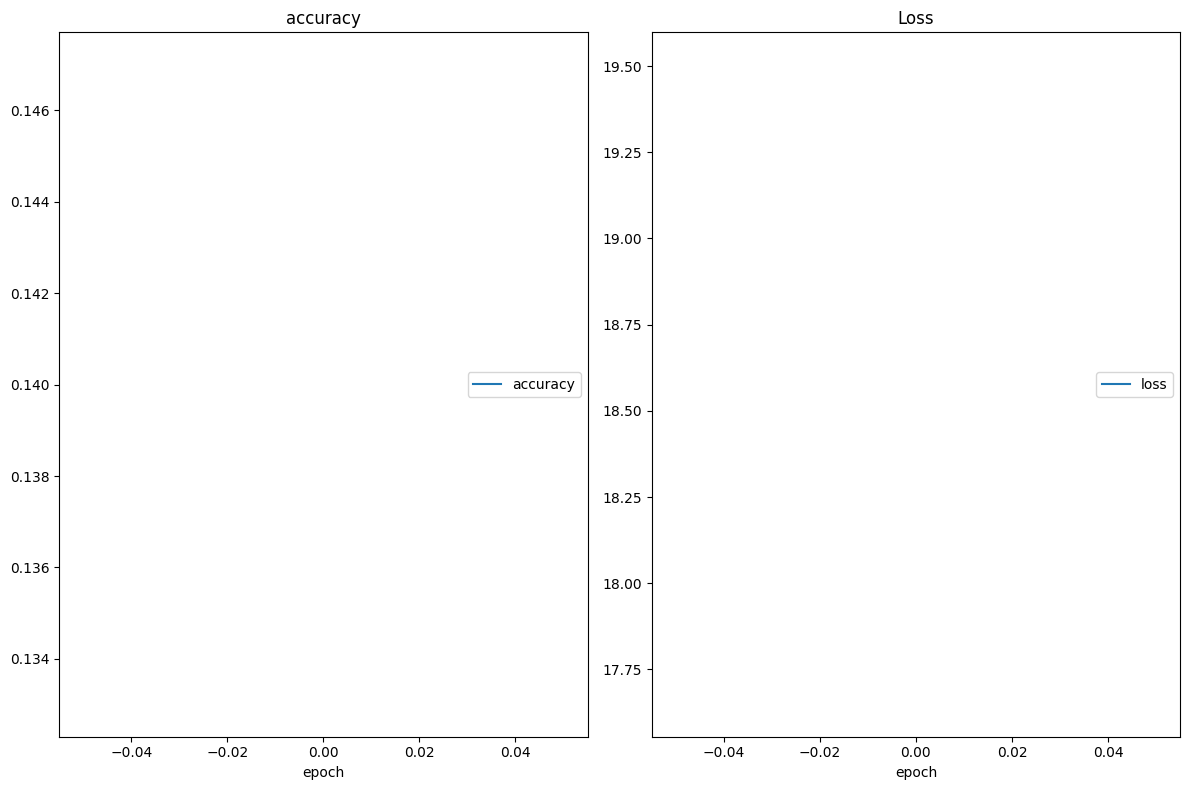

accuracy
	accuracy         	 (min:    0.140, max:    0.140, cur:    0.140)
Loss
	loss             	 (min:   18.576, max:   18.576, cur:   18.576)


KeyboardInterrupt: 

In [ ]:
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

num_epochs = 4

# Defining as global the device to use (by default CPU).
device = torch.device("cuda")

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0


# Training Loop.
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.to(device)
        text_masks = text_masks.to(device)
        labels = labels.to(device)

        # Compute predictions.
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()

        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1

    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
      for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
          # Move to GPU.
          texts = texts.to(device)
          text_masks = text_masks.to(device)
          labels = labels.to(device)

          # Compute predictions.
          predicted = model(texts, text_masks)

          # Compute loss.
          loss = cost_function(predicted.logits, labels)

          # Compute cumulative loss and top-5 accuracy.
          cumulative_loss += loss.data.sum().item()
          cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
          num_samples += texts.size(0)

          if batch_id % 100 == 0:
              logs['val_loss'] = cumulative_loss / num_samples
              logs['val_accuracy'] = cumulative_accuracy / num_samples
              liveloss.update(logs, current_step)
              liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

##### **2.4. Loading model weights from a file**
Training the model in the previous section might take about an hour -- instead we can load a model that has been pretrained already. Feel free to retrain but here I provide a model I trained myself by running the code in the preceding section.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
!gdown --id 1i0SFmNWptEwfkK8cH6pAm9BdO3LC0owV -O /content/drive/My\ Drive/best_roberta_model_so_far-comp646-spring2024.pth
import torch
data = torch.load('/content/drive/MyDrive/best_roberta_model_so_far-comp646-spring2024.pth')
torch.save(data, '/content/best_roberta_model_so_far-comp646-spring2024.pth')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1i0SFmNWptEwfkK8cH6pAm9BdO3LC0owV
From (redirected): https://drive.google.com/uc?id=1i0SFmNWptEwfkK8cH6pAm9BdO3LC0owV&confirm=t&uuid=9dee154f-906c-4cf1-8195-cbc35a210b72
To: /content/drive/My Drive/best_roberta_model_so_far-comp646-spring2024.pth
100% 499M/499M [00:13<00:00, 38.3MB/s]


In [ ]:
# I uploaded a "checkpoint" of this model that I trained on Google Drive.

# Try saving and uploading your model to Google Drive as well.
#!gdown 1kn4lza3l17AVlUFkpFah0MOvBTHsvWk1 # This won't work sometimes.
# The link below will always work but will be slower.
#!wget -nc https://www.cs.rice.edu/~vo9/deep-vislang/best_roberta_model_so_far-comp646-spring2024.pth
model.load_state_dict(torch.load('best_roberta_model_so_far-comp646-spring2024.pth'))
model.eval();

##### **2.5 Show the predictions for a few input texts**


In [ ]:
from transformers import RobertaTokenizer
import textwrap

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
wrapper = textwrap.TextWrapper(width=85)

def show_top5_predictions_for_movie_id(model, val_data, movie_id):
  # Extract data for the specific movie ID
  img, text, text_mask, labels = val_data[movie_id]

  # Move to GPU if available
  text = text.to(device)
  text_mask = text_mask.to(device)

  # Generate predictions
  with torch.no_grad():
      predicted = model(text.unsqueeze(0), text_mask.unsqueeze(0))

  # Apply sigmoid to convert logits to probabilities
  probs = torch.sigmoid(predicted.logits).squeeze()

  # Get top 5 predictions
  top5_probs, top5_labels = torch.topk(probs, 5)

  # Print the input text
  print("##################                        INPUT                        ##################")
  print("#########################################################################################")
  # Decode the text from token IDs to string
  text_str = tokenizer.decode(text.tolist(), skip_special_tokens=True)
  wrapped_text = wrapper.fill(text_str)
  print(f"{wrapped_text}")
  print("#########################################################################################")

  for prob, label in zip(top5_probs, top5_labels):
      print(f"P[{label.item()}] = {prob.item():.2f}")
  print("\n")

  print("Ground Truth Labels: ", [val_data.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])
  return labels, probs
def show_result(model, val_data, movie_ids):
    infos = {}  # Initialize an empty dictionary to store information for each movie
    for movie_id in movie_ids:
        labels, probs = show_top5_predictions_for_movie_id(model, val_data, movie_id)  # Ensure this function returns a tuple
        infos[movie_id] = (labels, probs)  # Use movie_id as the key to store labels and probabilities
    return infos

# Example usage
sample_movieIDs = [12, 13, 123]
outputs = show_result(model, val_data, sample_movieIDs)



##################                        INPUT                        ##################
#########################################################################################
In 16th-century Prague, a rabbi creates a giant creature from clay, called the Golem,
and using sorcery, brings the creature to life in order to protect the Jews of Prague
from persecution.
#########################################################################################
P[10] = 0.97
P[8] = 0.67
P[13] = 0.31
P[2] = 0.19
P[3] = 0.17


Ground Truth Labels:  ['Fantasy', 'Horror']
##################                        INPUT                        ##################
#########################################################################################
After a long wait, a young doctor finally has a patient come to his office. She is a
young woman whose father has brought her to be treated for sleep-walking, but the
father becomes annoyed with the doctor, and takes his daughter away. Soon afterward,


##### **2.6 Compute the mean average precision (meanAP) of this model **


In [ ]:
import torch
from sklearn.metrics import average_precision_score
import numpy as np


def meanAP_calculation(model, val_loader):
  real_value = []
  predict_value = []

  for img, text, text_mask, labels in val_loader:

    # Move tensors to the same device as the model
    text = text.to(device)
    text_mask = text_mask.to(device)
    labels = labels.to(device)  # True labels

    # Get model predictions
    with torch.no_grad():
      outputs = model(text, attention_mask=text_mask).logits

    # Store predictions and true labels
    real_value.append(labels.cpu().numpy())
    predict_value.append(outputs.cpu().numpy())

  # Concatenate all batches
  real_value = np.concatenate(real_value, axis=0)
  predict_value = np.concatenate(predict_value, axis=0)

  return average_precision_score(real_value, predict_value, average='macro')

mean_ap = meanAP_calculation(model, val_loader)
print(f"Mean Average Precision (all categories): {mean_ap:.4f}")


Mean Average Precision (all categories): 0.5352


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


##### **2.6. Show the posters for movies rated as Adventure with the highest score by the RoBERTa model.**

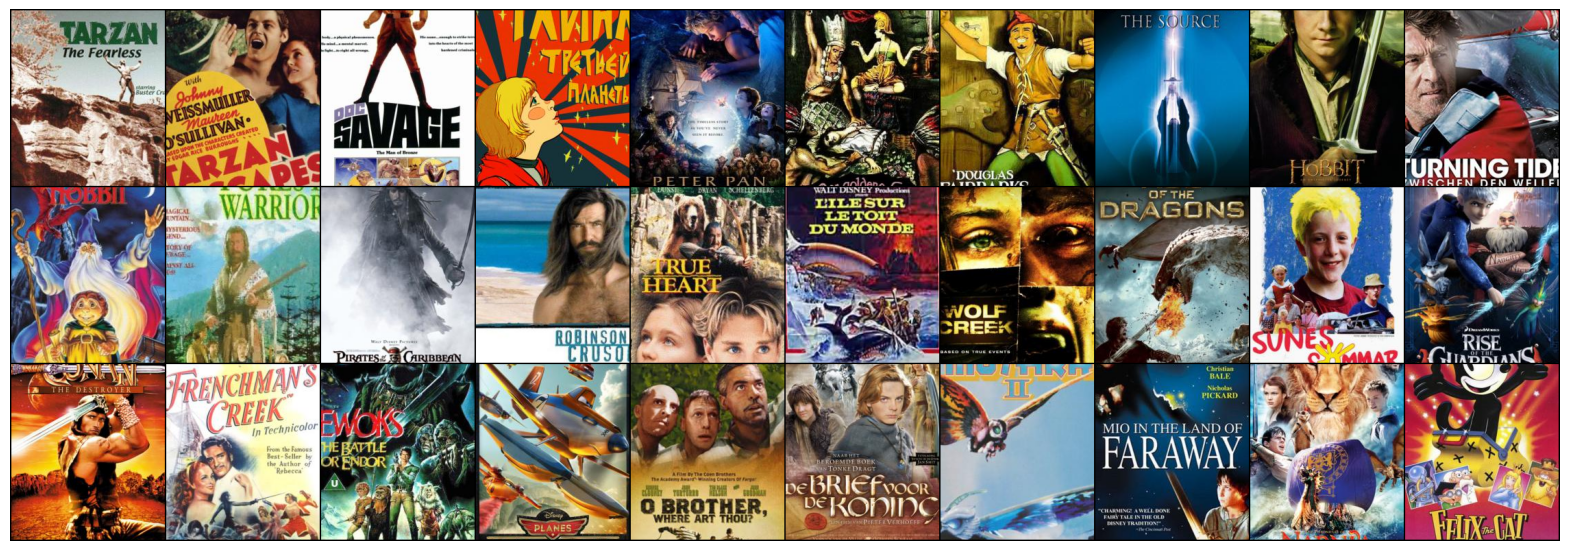

In [ ]:

movieType = 'Adventure'

genre_scores = []

for movie_id in range(len(val_data)):
  # 提取数据
  img, text, text_mask, labels = val_data[movie_id]
  text = text.to(device)
  text_mask = text_mask.to(device)
  with torch.no_grad():
    predicted = model(text.unsqueeze(0), text_mask.unsqueeze(0))
  # Apply sigmoid to convert logits to probabilities
  probs = torch.sigmoid(predicted.logits).squeeze()

  # 存储特定类型的概率
  genre_index = val_data.categories.index(movieType)  # 获取类型索引
  genre_scores.append((movie_id, probs[genre_index].item()))

top_movie_ids = [movie_id for movie_id, _ in sorted(genre_scores, key=lambda x: x[1], reverse=True)[:30]]

show_image_group(val_data, top_movie_ids, 30)

#### **3. Classify the Movies into Genres (based on their Posters -- Images) **




In [15]:
def meanAP_calculation(model, val_loader):
    real_value = []
    predict_value = []

    for imgs, _, _, labels in val_loader:

        imgs = imgs.to(device)
        labels = labels.to(device)  # True labels

        with torch.no_grad():
            outputs = model(imgs)  # Get model predictions for images

        # Store predictions and true labels
        real_value.append(labels.cpu().numpy())
        predict_value.append(outputs.sigmoid().cpu().numpy())

    real_value = np.concatenate(real_value, axis=0)
    predict_value = np.concatenate(predict_value, axis=0)

    return average_precision_score(real_value, predict_value, average='macro')


In [18]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
class OtherModel(nn.Module):
    def __init__(self, num_classes=27):
        super(OtherModel, self).__init__()
        # Load a pretrained ResNet50 model
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(self.model.children())[:-1])

        in_features = self.model.fc.in_features  # Assuming this is the number of input features for the conv layer

        # Adjusted additional convolutional layers with an increased depth
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_features, in_features // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features // 2, in_features // 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features // 4),
            nn.ReLU(inplace=True)
        )

        # Adjusted classifier with an additional fully connected layer and dropout for regularization
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features // 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # Apply adaptive pooling to reduce to a fixed size output
        x = F.adaptive_avg_pool2d(x, output_size=(1, 1))
        x = self.conv_layers(x)
        x = self.classifier(x)

        return x

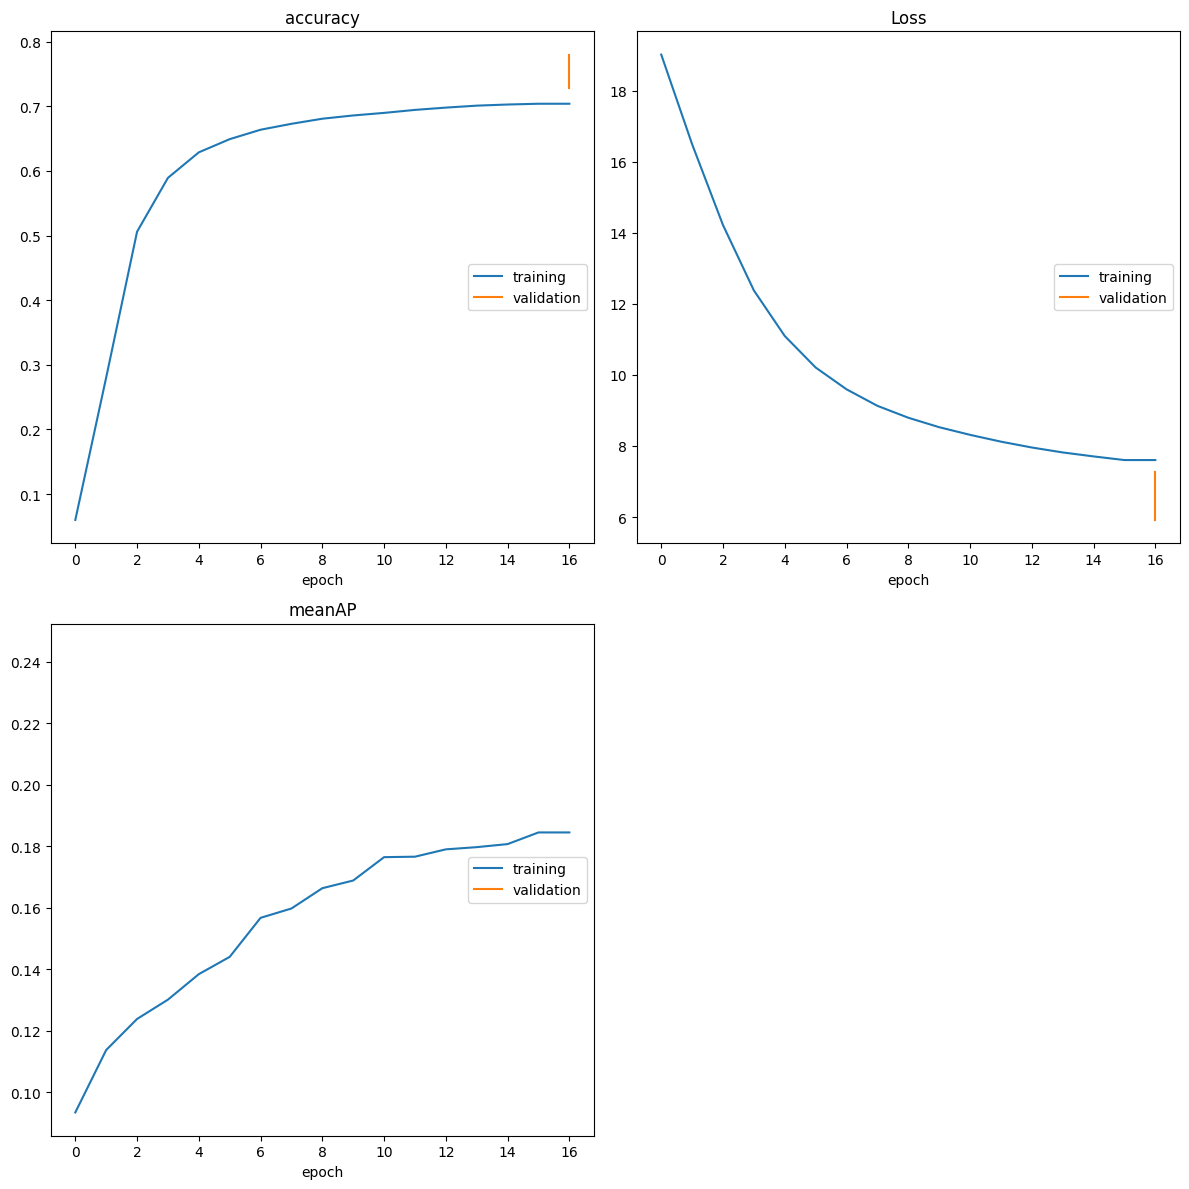

accuracy
	training         	 (min:    0.060, max:    0.704, cur:    0.704)
	validation       	 (min:    0.728, max:    0.780, cur:    0.728)
Loss
	training         	 (min:    7.604, max:   19.022, cur:    7.604)
	validation       	 (min:    5.917, max:    7.268, cur:    5.917)
meanAP
	training         	 (min:    0.093, max:    0.184, cur:    0.184)
	validation       	 (min:    0.245, max:    0.245, cur:    0.245)
Total training time: 500.33 seconds


In [21]:
!pip install livelossplot
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn
import time
num_epochs = 1

# Defining as global the device to use (by default CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OtherModel().to(device)
# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

# Training Loop.
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
start_time = time.time()
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Compute predictions.
        predicted = model(imgs)

        # Compute loss.
        loss = cost_function(predicted, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()

        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            mean_ap = meanAP_calculation(model, val_loader)
            logs['meanAP'] = mean_ap
            liveloss.update(logs)
            liveloss.send()
            current_step += 1

    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
      for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
          # Move to GPU.
          imgs = imgs.to(device)
          labels = labels.to(device)

          # Compute predictions.
          predicted = model(imgs)

          # Compute loss.
          loss = cost_function(predicted, labels)

          # Compute cumulative loss and top-5 accuracy.
          cumulative_loss += loss.data.sum().item()
          cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
          num_samples += texts.size(0)

          if batch_id % 100 == 0:
              logs['val_loss'] = cumulative_loss / num_samples
              logs['val_accuracy'] = cumulative_accuracy / num_samples
              mean_ap = meanAP_calculation(model, val_loader)
              logs['val_meanAP'] = mean_ap
              liveloss.update(logs, current_step)
              liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

**Required answer:** Is this model better than the text classifier in terms of top-5 accuracy as computed earlier? Which one is better?

#### **4. Zero-shot Text Classification with FLAN-T5 **

Some really impressive tools have been developed in the past few years with transformer neural networks. Auto-regressive neural networks allow one to predict the next element in a sequence given the previous elements. We can cast almost any problem involving text in this way incluing text classification. In December 2022 Google released [FLAN-T5](https://arxiv.org/pdf/2210.11416.pdf), a powerful language model that on top of being pre-trained to predict the next word in a sequence, it was finetuned to follow instructions for a variety of tasks. The following figure shows some examples:
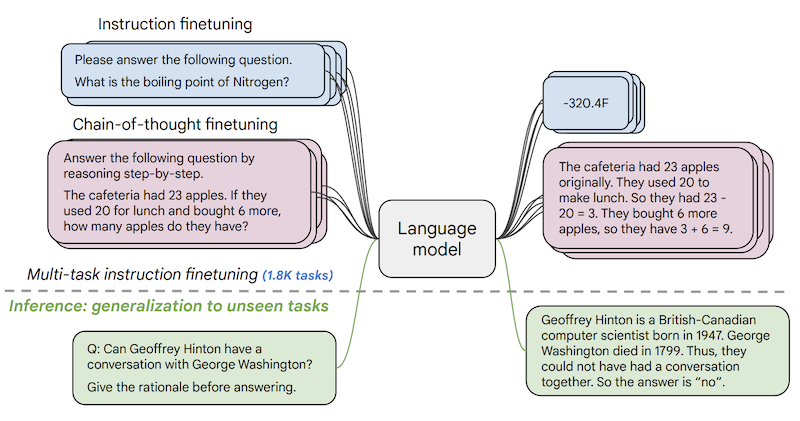


This network is included in the Hugginface transformers 🤗 library and you can try it interactively here: https://huggingface.co/google/flan-t5-xl

Use this network to predict the genre of the movies from the MMIMDB dataset. 

In [1]:
!pip -q install transformers==4.26.0
!pip -q install sentencepiece
!pip -q install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the language model and its tokenizer.
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl")
model = model.to('cuda')

# Load a smaller language model if the above proves hard during development.
#tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
#model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")
#model = model.to('cuda')

Replace the cell below with your solution, you need to report the meanAP for your solution.

In [10]:
import torch
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import average_precision_score
import re

# Assuming MovieDataset is defined and loaded as per the given structure
# Load the FLAN-T5 large model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")
model = model.to('cuda')  # Use CUDA if available

total_time = 0

def extract_genres_from_output(output_text, all_genres):
    """
    Use regex to accurately match genres in the model's output.
    """
    predicted_genres = []
    for genre in all_genres:
        if re.search(r'\b' + re.escape(genre.lower()) + r'\b', output_text.lower()):
            predicted_genres.append(genre)
    return predicted_genres

def convert_genres_to_binary(predicted_genres, all_genres):
    """
    Convert predicted genres into a binary vector.
    """
    binary_vector = np.zeros(len(all_genres))
    for genre in predicted_genres:
        if genre in all_genres:
            binary_vector[all_genres.index(genre)] = 1
    return binary_vector

def predict_and_score(model, tokenizer, plot_text, all_genres):
    """
    Generate genre predictions for a given plot text and convert to binary format.
    """
    # Enhanced prompt
    input_text = f"Given the plot: '{plot_text}', which genres from the following list does it belong to? {', '.join(all_genres)}"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

    # Generate predictions
    with torch.no_grad():
        outputs = model.generate(input_ids, max_new_tokens=50, temperature=0.8, top_k=50, return_dict_in_generate=True)

    output_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    predicted_genres = extract_genres_from_output(output_text, all_genres)
    predicted_labels = convert_genres_to_binary(predicted_genres, all_genres)

    return predicted_labels

# Load the dataset
valset = MovieDataset(split='dev', tokenizer=RobertaTokenizer.from_pretrained('roberta-base'))

# Initialize variables for meanAP calculation
predicted_scores = []
true_labels = []

start_time = time.time()

for sample_movieID in range(len(valset)):
    data = valset[sample_movieID]
    img, text, text_mask, labels = data
    plot_text = valset.tokenizer.decode(text.tolist(), skip_special_tokens=True)

    predicted_labels = predict_and_score(model, tokenizer, plot_text, valset.categories)
    predicted_scores.append(predicted_labels)
    true_labels.append(labels.numpy())

end_time = time.time()
total_time += (end_time - start_time)

# Calculate meanAP
meanAP = average_precision_score(np.array(true_labels), np.array(predicted_scores), average='macro')
print(f"Mean Average Precision: {meanAP:.4f}")
print(f"The total time prediction time: {total_time:.4f} seconds")

Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished
Mean Average Precision: 0.1912
The total time prediction time: 345.8168 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


#### **5. Zero-shot Image Classification with CLIP **



In January 2021, OpenAI published a research paper named CLIP ([Contrastive Language-Image Pretraining](https://arxiv.org/abs/2103.00020)) https://openai.com/blog/clip/. This model was trained to maximize the dot product between vector representations of text and images that have a direct correspondence and minimize their dot product when they do not correspond. One key property of this model is that it can be used to build zero-shot classifier. Since the model was trained on a large number of images and text from the web, this model knows about a lot of categories of things. My goal in this section is to obtain the best results using the illustrated approach 


In [1]:
# download data
# This command downloads the files with the prepackaged contents.
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
!tar xf SUN20-train-sm.tar.gz
!tar xf SUN20-val.tar.gz

--2024-02-12 23:48:32--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz [following]
--2024-02-12 23:48:34--  https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39744791 (38M) [application/x-gzip]
Saving to: ‘SUN20-train-sm.tar.gz’

SUN20-train-sm.tar. 100%[===================>]  37.90M   549KB/s    in 71s     

2024-02-12 23:49:46 (543 KB/s) - ‘SUN20-train-sm.tar.gz’ saved [39744791/39744791]

--2024-02-12 23:49:46--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connectin

In [2]:
# Creating a Custom Data Loader
import os, json, pickle, random
import torch.utils.data
from PIL import Image

# Simple implementation of a custom data loading class for our SUN20 dataset.
class SUN20(torch.utils.data.Dataset):

  # Initialize the class e.g. load files, preprocess, etc.
  def __init__(self, split = 'train', transform = None):

    # These are the 20 categories selected.
    self.categories = open('SUN20/' + split + '/ClassName.txt').read().split('\n')[:-1]
    self.categories = sorted(self.categories)
    self.category2index = {category: idx for (idx, category) in enumerate(self.categories)}
    self.transform = transform

    # Compile a list of images and corresponding labels.
    self.imagepaths = []
    self.labels = []
    for category in self.categories:
      category_directory = 'SUN20/' + split + category
      category_imagenames = os.listdir(category_directory)
      self.imagepaths += [os.path.join(category_directory, imagename)
                          for imagename in category_imagenames]
      self.labels += [self.category2index[category]] * len(category_imagenames)

    # Sort imagepaths alphabetically and labels accordingly.
    sorted_pairs = sorted(zip(self.imagepaths, self.labels), key = lambda x: x[0])
    self.imagepaths, self.labels = zip(*sorted_pairs)


  # Return a sample (x, y) as a tuple e.g. (image, label)
  def __getitem__(self, index):
    image = Image.open(self.imagepaths[index]).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, self.labels[index]

  # Return the total number of samples.
  def __len__(self):
    return len(self.imagepaths)


In [3]:
#load the dataset and CLIP model
!pip install clip
!pip install --upgrade git+https://github.com/openai/CLIP.git
import clip
import torchvision.transforms as transforms

  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6989 sha256=fd905d34cfe5ca10ea937755b040082080e3dec36518552430f47c55d31ee516
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1e50reqj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1e50reqj
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=7b6c3bfb938ed5eeb57c507711ff76085df619aa0bcf510eb33230d12f6e14e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-a5iehwjt/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4

In [4]:
# model, preprocess = clip.load('ViT-B/32', device="cuda")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])

valset = SUN20(split = 'val',transform=transform)
batch_size = 32
val_loader = torch.utils.data.DataLoader(valset,
                                         batch_size = batch_size,
                                         shuffle = False)


In [5]:
import clip
import torch
import time

device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


labels = ['arch', 'bathroom', 'butte', 'dentists office', 'hot spring', 'indoor jacuzzi', 'laundromat', 'lecture room', 'indoor library', 'lighthouse', 'living room', 'mansion', 'marsh', 'mountain', 'sauna', 'shower', 'skyscraper', 'tower', 'tree house', 'volcano']
text_descriptions = [f"This is a photo of a {label}" for label in labels]
text_tokens = clip.tokenize(text_descriptions).to(device)


with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

model.eval()
correct = 0
n_samples = 0
total_time = 0

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        start_time = time.time()

        image_features = model.encode_image(xb).float()
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.topk(1, dim=-1)

        end_time = time.time()
        total_time += (end_time - start_time)

        correct += (top_labels.squeeze(dim=1) == yb).sum().item()
        n_samples += xb.size(0)

accuracy = correct / n_samples
average_time_per_batch = total_time / len(val_loader)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Average prediction time per batch: {average_time_per_batch:.4f} seconds")


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 111MiB/s]


Accuracy: 91.40%
Average prediction time per batch: 4.8674 seconds


In [6]:
print(f"The total time prediction time: {total_time:.4f} seconds")

The total time prediction time: 155.7579 seconds
